Mounting the drive for dataset

In [2]:

from google.colab import drive
drive.mount('/content/drive')


# replace the file path with the path where your data is present
_, _, files = next(os.walk("/content/drive/My Drive/dataset"))
file_count = len(files)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Getting the file count

In [3]:
_, _, files = next(os.walk("/content/drive/My Drive/dataset/globally_sclerotic_glomeruli"))
file_count = len(files)
print(file_count)
_, _, files1 = next(os.walk("/content/drive/My Drive/dataset/non_globally_sclerotic_glomeruli"))
file_count_1 = len(files1)
print(file_count_1)

1054
4704


Loading the dataset csv file

In [4]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/dataset/public.csv')

In [5]:
print(df.head())

                                                name  ground truth
0  S-2006-005094_PAS_1of2_64552732435c92704a3d37c...             0
1  S-2006-005094_PAS_1of2_64552732435c92704a3d37c...             0
2  S-2006-005094_PAS_1of2_64552732435c92704a3d37c...             0
3  S-2006-005094_PAS_1of2_64552732435c92704a3d37c...             0
4  S-2006-005094_PAS_1of2_64552732435c92704a3d37d...             0


In [6]:
print(df.columns)

Index(['name', 'ground truth'], dtype='object')


Splitting the the dataset into train, validation and test datasets with seperate directories for each category of images

In [7]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Directories containing images for each class
class1_dir = '/content/drive/My Drive/dataset/globally_sclerotic_glomeruli'
class0_dir = '/content/drive/My Drive/dataset/non_globally_sclerotic_glomeruli'

# Reading the CSV file into a DataFrame
data = pd.read_csv('/content/drive/My Drive/dataset/public.csv')

# Shuffling the data frame
data = data.sample(frac=1).reset_index(drop=True)

# Spliting the DataFrame into training, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['ground truth'])
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['ground truth'])

# Create directories for train, validation, and test data split
train_dir = 'train'
val_dir = 'validation'
test_dir = 'test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Moving the images to respective directories
def move_images(data, destination_dir):
    for index, row in data.iterrows():
        if row['ground truth'] == 0:
            source_dir = class0_dir
        else:
            source_dir = class1_dir

        source_path = os.path.join(source_dir, row['name'])
        destination_path = os.path.join(destination_dir, str(row['ground truth']), row['name'])

        # Create directories if they don't exist for each ground truth class
        os.makedirs(os.path.join(destination_dir, str(row['ground truth'])), exist_ok=True)

        # Move the image
        shutil.copy(source_path, destination_path)

# Move images to their respective directories for train, validation, and test data sets
move_images(train_data, train_dir)
move_images(val_data, val_dir)
move_images(test_data, test_dir)


In [8]:
train_data.to_csv('train_data.csv', index=False)

In [9]:
test_data.to_csv('test_data.csv', index=False)

In [10]:
val_data.to_csv('val_data.csv', index=False)

In [13]:
x = pd.read_csv('train_data.csv')

In [15]:
value_counts = x['ground truth'].value_counts()
print(value_counts)

0    2822
1     632
Name: ground truth, dtype: int64


If we see above, the data is little imbalanced with class - 0 data points which is non_globally_sclerotic_glomeruli are 2822 and with class 1 are 632. To handle this problem, I have added augmentation to class 1 images in the further parts of the code

In [71]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from itertools import chain

# training generator for class_0
train_datagen_0 = ImageDataGenerator(rescale=1./255)


train_generator_0 = train_datagen_0.flow_from_directory(
        'train/',
        classes = ['0'],
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')

# training generator for class_1 with augmentation
train_datagen_1 = ImageDataGenerator(rescale=1./255,horizontal_flip=True,rotation_range=90,vertical_flip=True)


train_generator_1 = train_datagen_1.flow_from_directory(
        'train/',
        classes = ['1'],
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')

def combined_generator(augmented_generator, original_generator):
    while True:
        augmented_data = next(augmented_generator)
        original_data = next(original_generator)
        # Concatenate the augmented and original data
        X_combined = np.concatenate([augmented_data[0], original_data[0]])
        y_augmented = augmented_data[1]
        y_original = original_data[1]
        # adjusting the value of label as the image datagenerator takes the label as 0 if only one class is provided
        y_augmented += 1
        y_combined = np.concatenate([y_augmented, y_original])
        yield X_combined, y_combined

train_generator = combined_generator(train_generator_1, train_generator_0)


# For validation
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        'validation/',
        classes = ['0', '1'],
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')


Found 2822 images belonging to 1 classes.
Found 632 images belonging to 1 classes.
Found 1152 images belonging to 2 classes.


In [72]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

Create a Sequential model using keras for training are CNN model

In [73]:


model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [74]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 57600)             0         
                                                                 
 dense_16 (Dense)            (None, 64)               

In [75]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [76]:
_, _, files0 = next(os.walk("train/0"))
file_count_0 = len(files0)
_, _, files1 = next(os.walk("train/1"))
file_count_1 = len(files1)
sample_count_train = file_count_0 + file_count_1
print(sample_count_train)

_, _, files0 = next(os.walk("validation/0"))
file_count_0 = len(files0)
_, _, files1 = next(os.walk("validation/1"))
file_count_1 = len(files1)
sample_count_val = file_count_0 + file_count_1
print(sample_count_val)

3454
1152


In [77]:

batch_size = 32
epochs = 5


history = model.fit(
    train_generator,
    steps_per_epoch = sample_count_train // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps= sample_count_val // batch_size)

Epoch 1/5
107/107 [==============================] - 448s 4s/step - loss: 0.3179 - accuracy: 0.8645 - val_loss: 0.2886 - val_accuracy: 0.8993
Epoch 2/5
107/107 [==============================] - 423s 4s/step - loss: 0.0999 - accuracy: 0.9630 - val_loss: 0.5320 - val_accuracy: 0.8585
Epoch 3/5
107/107 [==============================] - 439s 4s/step - loss: 0.0759 - accuracy: 0.9728 - val_loss: 0.3495 - val_accuracy: 0.8941
Epoch 4/5
107/107 [==============================] - 414s 4s/step - loss: 0.0491 - accuracy: 0.9847 - val_loss: 0.4792 - val_accuracy: 0.8646
Epoch 5/5
107/107 [==============================] - 414s 4s/step - loss: 0.0358 - accuracy: 0.9896 - val_loss: 0.4641 - val_accuracy: 0.8811


Prepare test data generator

In [78]:

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'test/',
        classes = ['0', '1'],
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')

Found 1152 images belonging to 2 classes.


In [79]:
y_pred = model.predict(test_generator, verbose=1)

36/36 [==============================] - 63s 2s/step


In [80]:
y_pred

array([[7.9187989e-02],
       [1.8940609e-08],
       [6.0304844e-11],
       ...,
       [2.0553985e-09],
       [3.1824253e-04],
       [4.8855829e-05]], dtype=float32)

Converting prediction probabilities into binary classification by using a threshold of 0.5

In [85]:
model.evaluate(test_generator)

36/36 [==============================] - 55s 2s/step - loss: 0.4876 - accuracy: 0.8733


[0.48764345049858093, 0.8732638955116272]

In [81]:
binary_predictions = np.where(y_pred > 0.5, 1, 0)

Confusion matrix to evaluate the predictions

In [82]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(test_generator.classes, binary_predictions)

In [83]:
print(conf_matrix)

[[881  60]
 [192  19]]


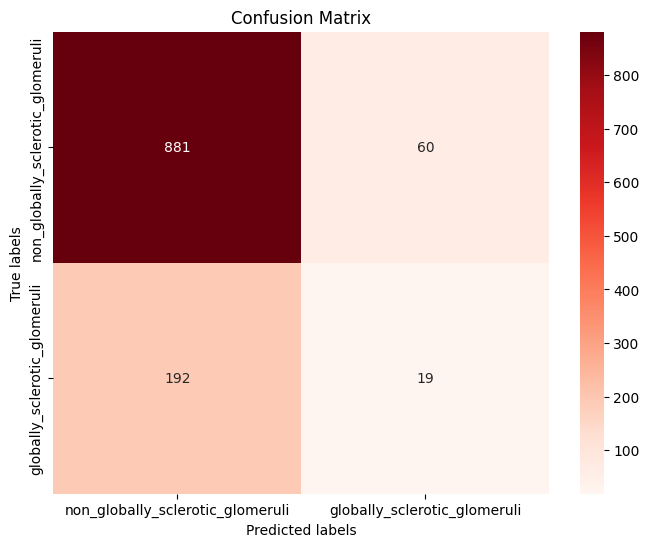

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['non_globally_sclerotic_glomeruli', 'globally_sclerotic_glomeruli']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [70]:
model.evaluate(test_generator)

36/36 [==============================] - 50s 1s/step - loss: 0.3319 - accuracy: 0.8967


[0.3318663239479065, 0.8967013955116272]

Saving the model

In [86]:
# Save the weights
model.save_weights('model_weights.h5')

Loading the saved model weights

In [93]:
model_new = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [94]:
model_new.load_weights('model_weights.h5')

In [98]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [99]:
loss, accuracy = model_new.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

36/36 [==============================] - 58s 2s/step - loss: 0.4876 - accuracy: 0.8733
Test Loss: 0.4876435697078705
Test Accuracy: 0.8732638955116272
